In [17]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from torch_mist import estimate_mi
from matplotlib.image import imread
from torchvision import transforms
import seaborn as sns
import struct

def load_mnist_images(path):
    with open(path, 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.fromfile(f, dtype=np.uint8)
        data = data.reshape(size, rows, cols)
    return data

# Ta fonction de décalage (optimisée PyTorch)
def decalage_bit_tensor(tensor, s):
    # 1. Conversion Float [0, 1] -> Int [0, 255] (uint8)
    img_int = (tensor * 255).round().to(torch.uint8)
    # 2. Décalage de bits
    shifted_int = img_int << s
    # 3. Retour en Float [0, 1]
    return shifted_int.float() / 255.0

def bruit_gaussien_tensor(tensor, sigma):
    
    img_scaled = tensor * 255.0
    noise = torch.randn_like(img_scaled) * sigma
    noisy_img = img_scaled + noise
    noisy_img = torch.clamp(noisy_img, 0, 255)

    # 4. Retour en Float [0, 1]
    return noisy_img / 255.0
def identity(tensor, s):
    img_same = (tensor * 255).round().to(torch.uint8).float() / 255.0
    return img_same
def identity_same(tensor, s):
    return tensor


exemple d'utilisation avec MNIST (les chiffres)

In [18]:
from typing import Callable
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset

# Simple wrapper to create pairs (x,y) of images
class PairedMNIST(MNIST):
    def __init__(self, root: str, transform: Callable, *args, **kwargs):
        super().__init__(root, *args, **kwargs)
        self._transform = transform

    def __getitem__(self, index: int):
        image, label = super().__getitem__(index)
        image_1 = self._transform(image)
        image_2 = self._transform(image)
        return {'x': image_1, 'y': image_2}
    # --- 2. CREATION DE LA TRANSFORMATION (WRAPPER) ---
class BitShift:
    """
    Transformation PyTorch personnalisée pour appliquer un décalage de bit.
    Peut être utilisée seule ou dans un Compose().
    """
    def __init__(self, s):
        self.s = s

    def __call__(self, img):
        # img est un tenseur [C, H, W]
        return decalage_bit_tensor(img, self.s)


# --- 3. DATASET ---
class PairedMemoryDataset(Dataset):
    def __init__(self, data_tensor, transform=None):
        self.data = data_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x_original = self.data[idx]
        if self.transform:
            x_augmented = self.transform(x_original)
        else:
            x_augmented = x_original
        return x_original, x_augmented


In [19]:
SHIFT_AMOUNT = 2

In [20]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import sys

# --- 1. CONFIGURATION ---
# Mettez le chemin EXACT (avec le 'r' devant)
path_coco_folder = r"C:\Users\barta\Documents\cours\iaprojets\PDR\code\datasets\coco\train2017\train2017"

IMG_SIZE = (64, 64)  
# IMPORTANT : Baissez ce chiffre si ça plante encore (ex: 2000 ou 5000)
# Une fois que ça marche, essayez d'augmenter petit à petit.
MAX_SAMPLES = 100 

# --- 2. FONCTION OPTIMISÉE (Moins de RAM) ---
def load_coco_images_optimized(folder_path, n_samples, img_size):
    """
    Charge les images directement dans un tenseur pré-alloué pour économiser la RAM.
    """
    valid_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(valid_files) == 0:
        raise FileNotFoundError(f"Aucune image trouvée dans : {folder_path}")
    
    # On limite au nombre de fichiers disponibles si n_samples est trop grand
    n_to_load = min(n_samples, len(valid_files))
    print(f"Tentative de chargement de {n_to_load} images...")

    # Pré-allocation du tenseur final (C'est là l'astuce mémoire)
    # [N, 1, 64, 64] rempli de zéros
    final_tensor = torch.zeros((n_to_load, 1, img_size[0], img_size[1]), dtype=torch.float32)

    pre_process = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor() 
    ])
    
    count = 0
    for i, filename in enumerate(valid_files):
        if count >= n_to_load:
            break
            
        img_path = os.path.join(folder_path, filename)
        try:
            # Convertir en Gris ('L')
            img = Image.open(img_path).convert('L')
            tensor_img = pre_process(img)
            
            # On insère directement dans le grand tenseur
            final_tensor[count] = tensor_img
            count += 1
            
            if count % 1000 == 0:
                print(f"Chargé : {count}/{n_to_load}")
                
        except Exception as e:
            print(f"Erreur image {filename}: {e}")

    # Si on a eu des erreurs et chargé moins que prévu, on coupe le surplus de zéros
    return final_tensor[:count]

# --- 3. EXÉCUTION SÉCURISÉE ---
tensor_coco = None # Initialisation explicite

try:
    tensor_coco = load_coco_images_optimized(path_coco_folder, MAX_SAMPLES, IMG_SIZE)
    print(f"SUCCÈS ! Tenseur COCO créé : {tensor_coco.shape}")
    
except Exception as e:
    print(f"ERREUR CRITIQUE : {e}")
    # On empêche la suite du code de s'exécuter inutilement
    raise e 

# --- 4. SUITE DU CODE (Se lance seulement si tensor_coco existe) ---
if tensor_coco is not None:
    # Votre transformation
    my_transform = BitShift(s=SHIFT_AMOUNT)

    train_set = PairedMemoryDataset(
        data_tensor=tensor_coco, 
        transform=my_transform
    )

    train_loader = DataLoader(train_set, batch_size=100, shuffle=True, num_workers=0)

    print("Création des vecteurs plats...")
    all_originals = []
    all_augmented = []

    for x_original, x_augmented in train_loader:
        x_original_flat = x_original.reshape(x_original.shape[0], -1)
        x_augmented_flat = x_augmented.reshape(x_augmented.shape[0], -1)
        
        all_originals.append(x_original_flat)
        all_augmented.append(x_augmented_flat)

    all_originals = torch.cat(all_originals, dim=0)
    all_augmented = torch.cat(all_augmented, dim=0)

    print(f"Terminé. Données prêtes pour MINE : {all_originals.shape}")

Tentative de chargement de 100 images...
SUCCÈS ! Tenseur COCO créé : torch.Size([100, 1, 64, 64])
Création des vecteurs plats...
Terminé. Données prêtes pour MINE : torch.Size([100, 4096])


In [21]:
#--- 3. FONCTIONS DE CALCUL MI ---
def hist1d(data, bins=256):
    """
    Calcule l'histogramme 1D normalisé (distribution de probabilité)
    data: array de valeurs de pixels (aplati)
    """
    hist, _ = np.histogram(data, bins=bins, range=(0, 255))
    return hist / hist.sum()  # Normalisation pour obtenir des probabilités

def hist2d(data_x, data_y, bins=256):
    """
    Calcule l'histogramme 2D normalisé (distribution jointe)
    data_x, data_y: arrays de valeurs de pixels (aplatis)
    """
    hist, _, _ = np.histogram2d(data_x, data_y, bins=bins, range=[[0, 255], [0, 255]])
    return hist / hist.sum()  # Normalisation

def calculate_true_mi(x_data, y_data, bins=256):
    """
    Calcule l'information mutuelle I(X;Y) par histogramme
    
    x_data: images originales (uint8, valeurs 0-255)
    y_data: images transformées (uint8, valeurs 0-255)
    """
    # Aplatir toutes les images en un seul vecteur
    x_flat = x_data.flatten()
    y_flat = y_data.flatten()
    
    print(f"Nombre total de pixels: {len(x_flat)}")
    print(f"Range X: [{x_flat.min()}, {x_flat.max()}]")
    print(f"Range Y: [{y_flat.min()}, {y_flat.max()}]")
    
    # Calcul des distributions marginales
    distrib_x = hist1d(x_flat, bins=bins)
    distrib_y = hist1d(y_flat, bins=bins)
    
    # Calcul de la distribution jointe
    jointdistrib_xy = hist2d(x_flat, y_flat, bins=bins)
    
    # Calcul de l'entropie H(X)
    h_x = 0
    for i in range(bins):
        if distrib_x[i] > 0:
            h_x += -distrib_x[i] * np.log2(distrib_x[i])
    
    # Calcul de l'information mutuelle I(X;Y)
    MI = 0
    for i in range(bins):
        px = distrib_x[i]
        for j in range(bins):
            py = distrib_y[j]
            pxy = jointdistrib_xy[i, j]
            
            if pxy > 0 and px > 0 and py > 0:
                MI += pxy * np.log2(pxy / (px * py))
    
    return MI, h_x


In [22]:
# --- 6. CALCUL DE LA VRAIE MI ---
# IMPORTANT: Conversion en uint8 pour l'histogramme
x_uint8 = (all_originals * 255).round().to(torch.uint8).numpy()  # [10000, 1, 28, 28]
y_uint8 = (all_augmented * 255).round().to(torch.uint8).numpy()    # [10000, 1, 28, 28]

print("\n" + "="*60)
print(f"Calcul de la vraie MI (histogramme) - Shift: {SHIFT_AMOUNT} bits")
print("="*60)

true_mi, h_x = calculate_true_mi(x_uint8, y_uint8, bins=256)

print(f"\nRésultats:")
print(f"  H(X) = {h_x:.4f} bits")
print(f"  I(X;Y) = {true_mi:.4f} bits")
print(f"  Shift appliqué: {SHIFT_AMOUNT} bits")
print(f"  Information perdue: {h_x - true_mi:.4f} bits")
print("="*60)


Calcul de la vraie MI (histogramme) - Shift: 2 bits
Nombre total de pixels: 409600
Range X: [0, 255]
Range Y: [0, 252]

Résultats:
  H(X) = 7.8792 bits
  I(X;Y) = 5.9983 bits
  Shift appliqué: 2 bits
  Information perdue: 1.8808 bits


Lancement du calcul sur 2 images...
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
Image 1/2 | MI Est.: 1.6619 | Entropie H(X): 4.9873
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
Image 2/2 | MI Est.: 1.9844 | Entropie H(X): 5.2670

--- RÉSULTATS GLOBAUX ---
MI Moyenne estimée : 1.8231
Entropie Moyenne H(X): 5.1271 (Cible théorique)


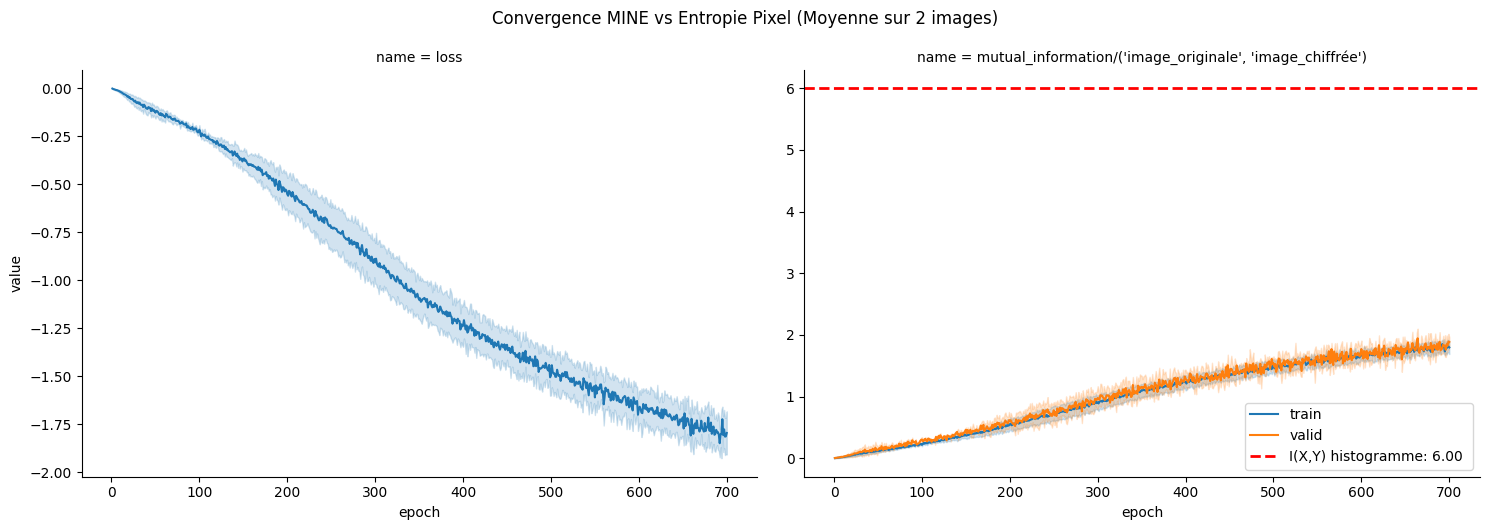

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch_mist import estimate_mi
from scipy.stats import entropy

# --- CONFIGURATION ---
n =2
all_logs = []
final_mi_values = []
all_entropies = []  # <--- Nouvelle liste pour stocker les entropies

# --- BOUCLE DE CALCUL ---
print(f"Lancement du calcul sur {n} images...")


for i in range(n):
    x_original = all_originals[i]
    x_chiffre = all_augmented[i]
    pixel_counts = pd.Series(x_original.flatten()).value_counts()
    # scipy.stats.entropy calcule -sum(p * ln(p)) (base e = nats par défaut)
    h_x = entropy(pixel_counts) 
    all_entropies.append(h_x)
    
    # 2. Création DataFrame
    df = pd.DataFrame({
        'image_originale': list(x_original),
        'image_chiffrée': list(x_chiffre) # Si Y = X, alors MI théorique = H(X)
    })
    
    # 3. Estimation MI (MINE)
    result, logs = estimate_mi(
        data=df,              
        x_key='image_originale',
        y_key='image_chiffrée',
        estimator='mine',
        hidden_dims=[128, 128],
        batch_size=1024,
        verbose=False,
        device='cuda',
        max_epochs=700,
        early_stopping=True,
        patience=10
    )
    
    mi_value = list(result.values())[0]
    final_mi_values.append(mi_value)
    
    logs['run_id'] = i
    all_logs.append(logs)
    
    print(f"Image {i+1}/{n} | MI Est.: {mi_value:.4f} | Entropie H(X): {h_x:.4f}")

# --- AGREGATION ---
full_history_df = pd.concat(all_logs, ignore_index=True)
average_mi = np.mean(final_mi_values)
average_entropy = np.mean(all_entropies) # <--- Moyenne des entropies

print(f"\n--- RÉSULTATS GLOBAUX ---")
print(f"MI Moyenne estimée : {average_mi:.4f}")
print(f"Entropie Moyenne H(X): {average_entropy:.4f} (Cible théorique)")

# --- VISUALISATION ---
g = sns.FacetGrid(
    full_history_df, 
    col='name', 
    hue='split', 
    sharey=False, 
    col_order=['loss', "mutual_information/('image_originale', 'image_chiffrée')"],
    height=5,
    aspect=1.5
)

g.map(sns.lineplot, 'epoch', 'value')

# --- AJOUT DE LA LIGNE D'ENTROPIE ---
# On cible le graphique de droite (index 1) qui contient la MI
ax_mi = g.axes[0, 1]

# Tracer la ligne horizontale rouge
ax_mi.axhline(
    y=true_mi, 
    color='red', 
    linestyle='--', 
    linewidth=2, 
    label=f'I(X,Y) histogramme: {true_mi:.2f} '
)

# Ajout de la légende pour la ligne rouge
ax_mi.legend()

g.figure.suptitle(f'Convergence MINE vs Entropie Pixel (Moyenne sur {n} images)', y=1.05)
plt.show()

#pour 10 images bit shit 5 = 2min de calculs 

In [24]:
g.map(sns.lineplot, 'epoch', 'value')

# --- AJOUT DE LA LIGNE D'ENTROPIE ---
# On cible le graphique de droite (index 1) qui contient la MI
ax_mi = g.axes[0, 1]

# Tracer la ligne horizontale rouge
ax_mi.axhline(
    y=true_mi, 
    color='red', 
    linestyle='--', 
    linewidth=2, 
    label=f'I(X,Y) histogramme: {true_mi:.2f} '
)
ax_mi.axhline(
    y=average_entropy, 
    color='green', 
    linestyle='--', 
    linewidth=2, 
    label=f'entropie moyenne H(X): {average_entropy:.2f} '
)

# Ajout de la légende pour la ligne rouge
ax_mi.legend()

g.figure.suptitle(f'Convergence MINE vs Entropie Pixel (Moyenne sur {n} images)', y=1.05)
plt.show()

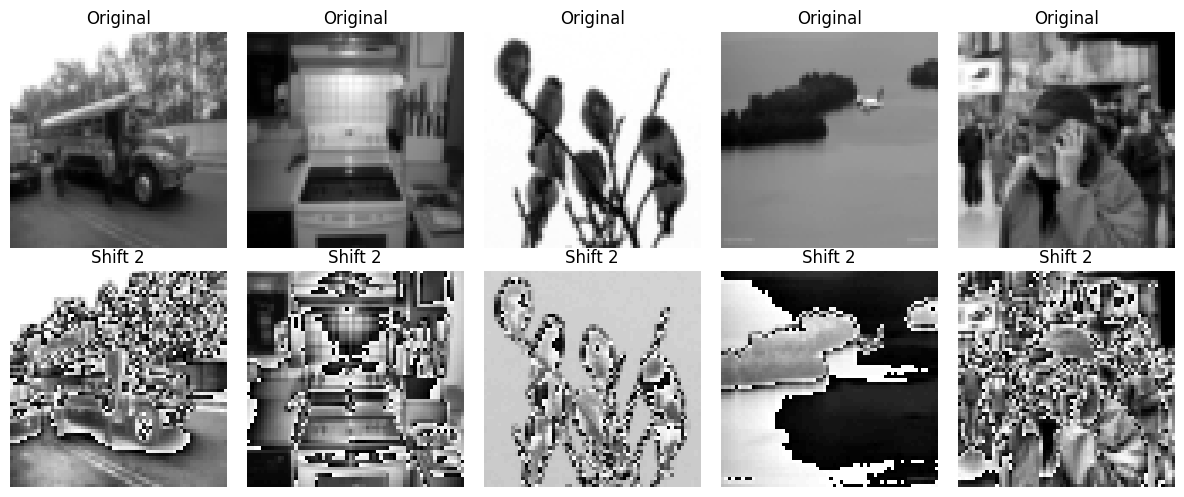

In [25]:
# --- 8. VISUALISATION (OPTIONNEL) ---
# Affichage de quelques paires pour vérifier
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(5):
    # Image originale
    axes[0, i].imshow(all_originals[i].reshape(64, 64), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')
    
    # Image chiffrée
    axes[1, i].imshow(all_augmented[i].reshape(64, 64), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Shift {SHIFT_AMOUNT}')
plt.tight_layout()
plt.show()

essayer de recoder mine avec des conv2d a la place de trucs linéaires. Creer des images avec des distributions données 